In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
sys.path.append(os.path.abspath('../programs/utils'))
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\namwonjin\\Documents\\Kaggle\\programs\\utils\\utils.py'>

In [2]:
# read train data and test data
dtypes = {'PassengerId':'object',
          'Survived':'int',
          'Pclass':'int',
          'Name':'object',
          'Sex':'object',
          'Age':'float',
          'SibSp':'float',
          'Parch':'float',
          'Ticket':'object',
          'Fare':'float',
          'Cabin':'object',
          'Embarked':'object'
          }
train_data = pd.read_csv('titanic_csv/train.csv',dtype=dtypes)
train_data['data_type'] = 'train'
test_data = pd.read_csv('titanic_csv/test.csv')
test_data['data_type'] = 'test'

In [54]:
datamart = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

# 1 Data overview

In [55]:
#Column	Description
# Pclass	Passenger class (1 = 1st class, 2 = 2nd class, 3 = 3rd class). Represents socio-economic status.
# Name	    Full name of the passenger, including title (e.g., Mr, Mrs, Miss, etc.).
# Sex	    Gender of the passenger (male or female).
# Age	    Age of the passenger in years. May contain missing values.
# SibSp	    Number of siblings or spouses the passenger had aboard the Titanic.
# Parch	    Number of parents or children the passenger had aboard.
# Ticket	Ticket number. Multiple passengers might share the same ticket.
# Fare	    Fare paid for the ticket (in British Pounds).
# Cabin	    Cabin number. Often includes deck letter (e.g., "C85"). A large portion of values are missing.
# Embarked	Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

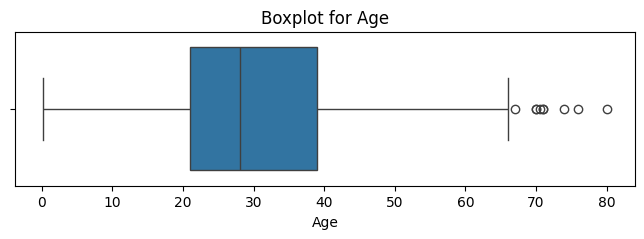

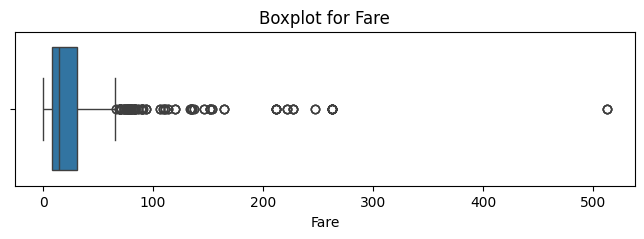

In [56]:
utils.plot_outliers(datamart,'Age')
utils.plot_outliers(datamart,'Fare')

In [57]:
null_summary_train = pd.DataFrame({
    'null_count': train_data.isnull().sum(),
    'null_ratio': train_data.isnull().mean()
})
print("train data null summary \n",null_summary_train, "\n")

null_summary_test = pd.DataFrame({
    'null_count': test_data.isnull().sum(),
    'null_ratio': test_data.isnull().mean()
})
print("test data null summary \n",null_summary_test)

train data null summary 
              null_count  null_ratio
PassengerId           0    0.000000
Survived              0    0.000000
Pclass                0    0.000000
Name                  0    0.000000
Sex                   0    0.000000
Age                 177    0.198653
SibSp                 0    0.000000
Parch                 0    0.000000
Ticket                0    0.000000
Fare                  0    0.000000
Cabin               687    0.771044
Embarked              2    0.002245
data_type             0    0.000000 

test data null summary 
              null_count  null_ratio
PassengerId           0    0.000000
Pclass                0    0.000000
Name                  0    0.000000
Sex                   0    0.000000
Age                  86    0.205742
SibSp                 0    0.000000
Parch                 0    0.000000
Ticket                0    0.000000
Fare                  1    0.002392
Cabin               327    0.782297
Embarked              0    0.000000
data_type  

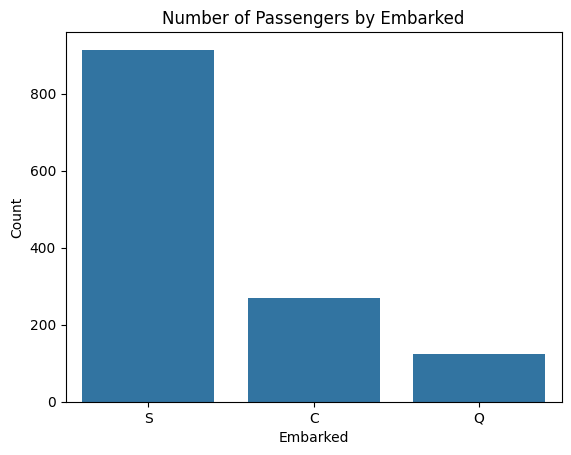

In [58]:
sns.countplot(x='Embarked', data=datamart)

plt.title("Number of Passengers by Embarked")
plt.ylabel("Count")
plt.xlabel("Embarked")
plt.show()
# Most people embarked from S.

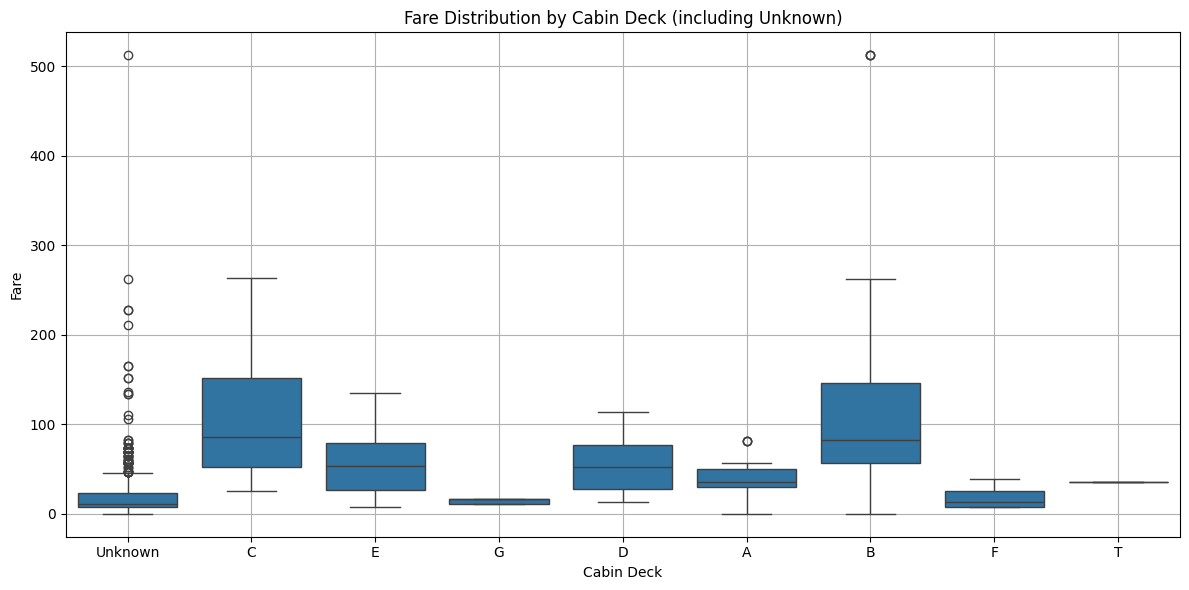

In [59]:
# Since the Cabin column has too many missing values and 
# is difficult to predict reliably based on fare, 
# it will be excluded from the analysis.
# Since the Pclass column already reflects some information about Cabin, 
# it may not be necessary to impute the missing Cabin values aggressively.

datamart['CabinDeck'] = datamart['Cabin'].astype(str).str[0]
datamart.loc[datamart['Cabin'].isnull(), 'CabinDeck'] = 'Unknown'
plt.figure(figsize=(12, 6))
sns.boxplot(data=datamart, x='CabinDeck', y='Fare')
plt.title("Fare Distribution by Cabin Deck (including Unknown)")
plt.xlabel("Cabin Deck")
plt.ylabel("Fare")
plt.grid(True)
plt.tight_layout()
plt.show()

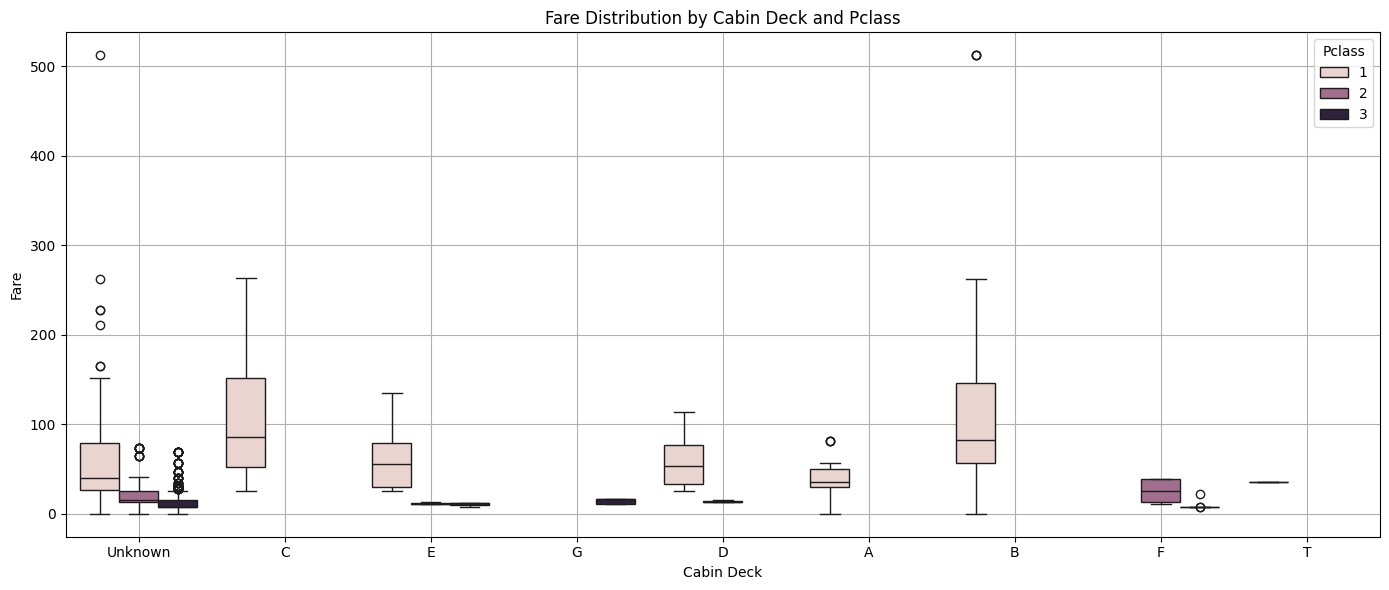

In [60]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=datamart, x='CabinDeck', y='Fare', hue='Pclass')
plt.title("Fare Distribution by Cabin Deck and Pclass")
plt.xlabel("Cabin Deck")
plt.ylabel("Fare")
plt.legend(title='Pclass')
plt.tight_layout()
plt.grid(True)
plt.show()

# A, B, C, D, E ->Maybe 1st Class?
# F, G, -> others?

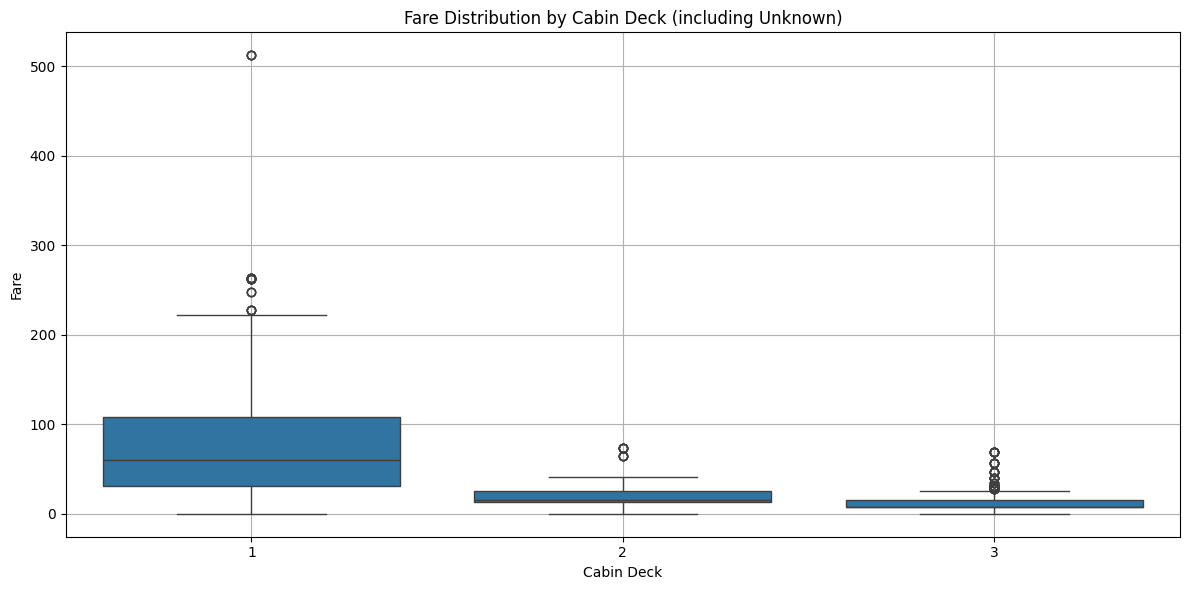

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=datamart, x='Pclass', y='Fare')
plt.title("Fare Distribution by Cabin Deck (including Unknown)")
plt.xlabel("Cabin Deck")
plt.ylabel("Fare")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# We first categorize the types of titles based on common social conventions.
datamart['Title'] = datamart['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
title_map = {
    "Mr": "Mr",
    "Miss": "Miss",
    "Mrs": "Mrs",
    "Master": "Master",
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Dr": "Professional",
    "Rev": "Clergy",
    "Major": "Military",
    "Col": "Military",
    "Capt": "Military",
    "Don": "Nobility",
    "Sir": "Nobility",
    "Lady": "Nobility",
    "Countess": "Nobility",
    "Jonkheer": "Nobility"
}

datamart['Title_fixed'] = datamart['Title'].map(title_map).fillna('Others')

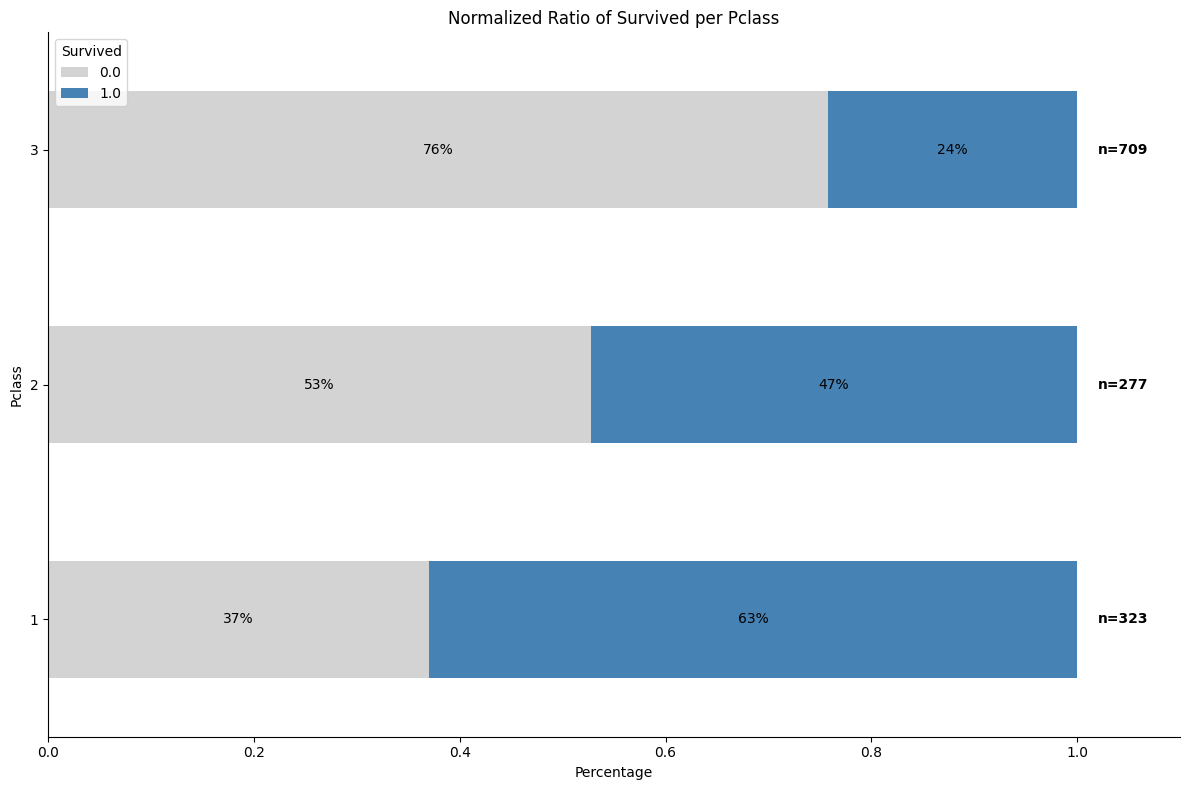

In [63]:
# Check the number of survivors by Pclass
utils.plot_binary_ratio_by_category(datamart, 'Pclass', 'Survived')
# 1st class has the highest survival rate, while 3rd class has the lowest.

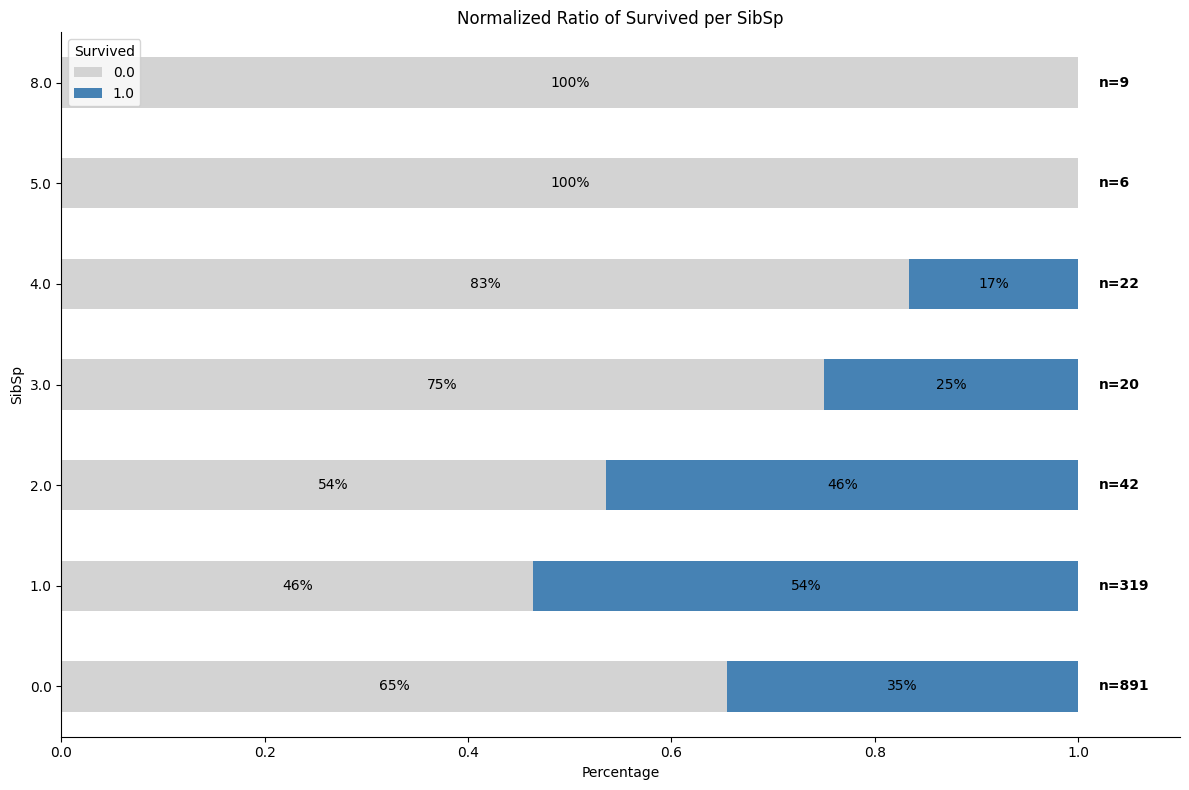

In [64]:
# Check the number of survivors by SibSp (number of siblings/spouses aboard)
utils.plot_binary_ratio_by_category(datamart, 'SibSp', 'Survived')

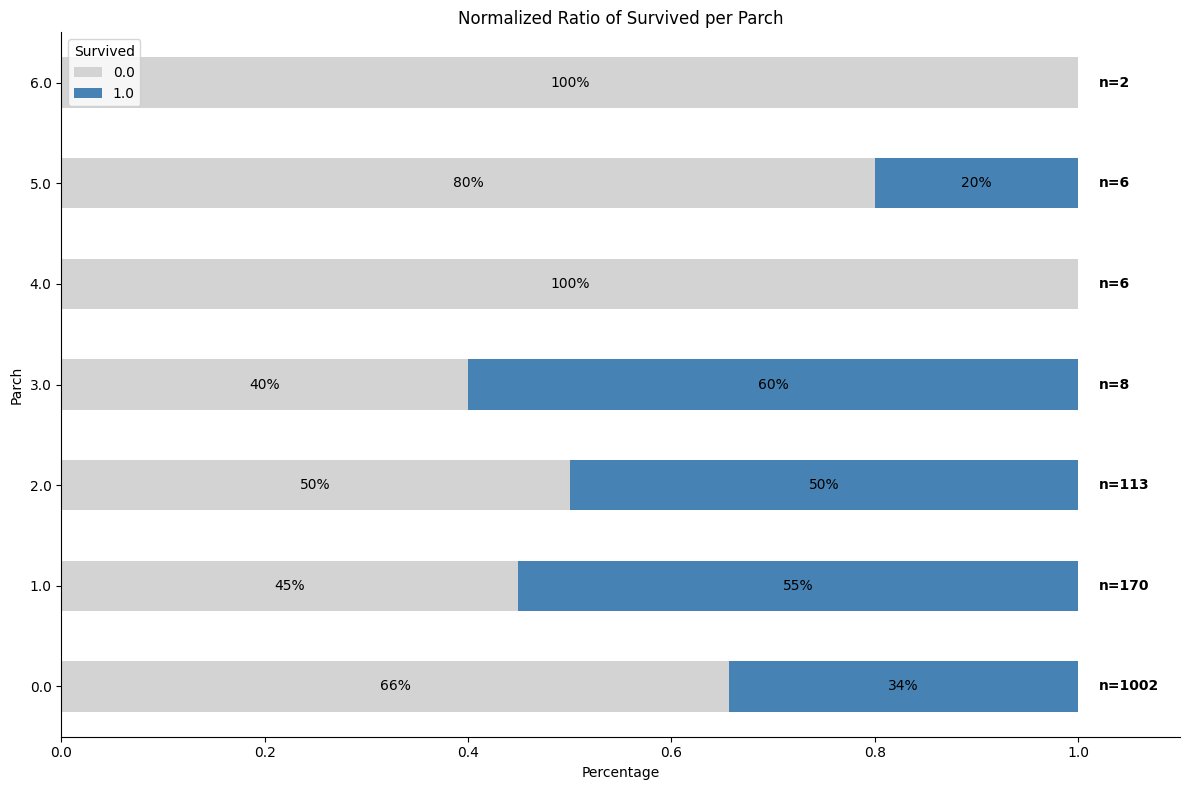

In [65]:
# Check the number of survivors by Parch (number of parents/children aboard)
utils.plot_binary_ratio_by_category(datamart, 'Parch', 'Survived')

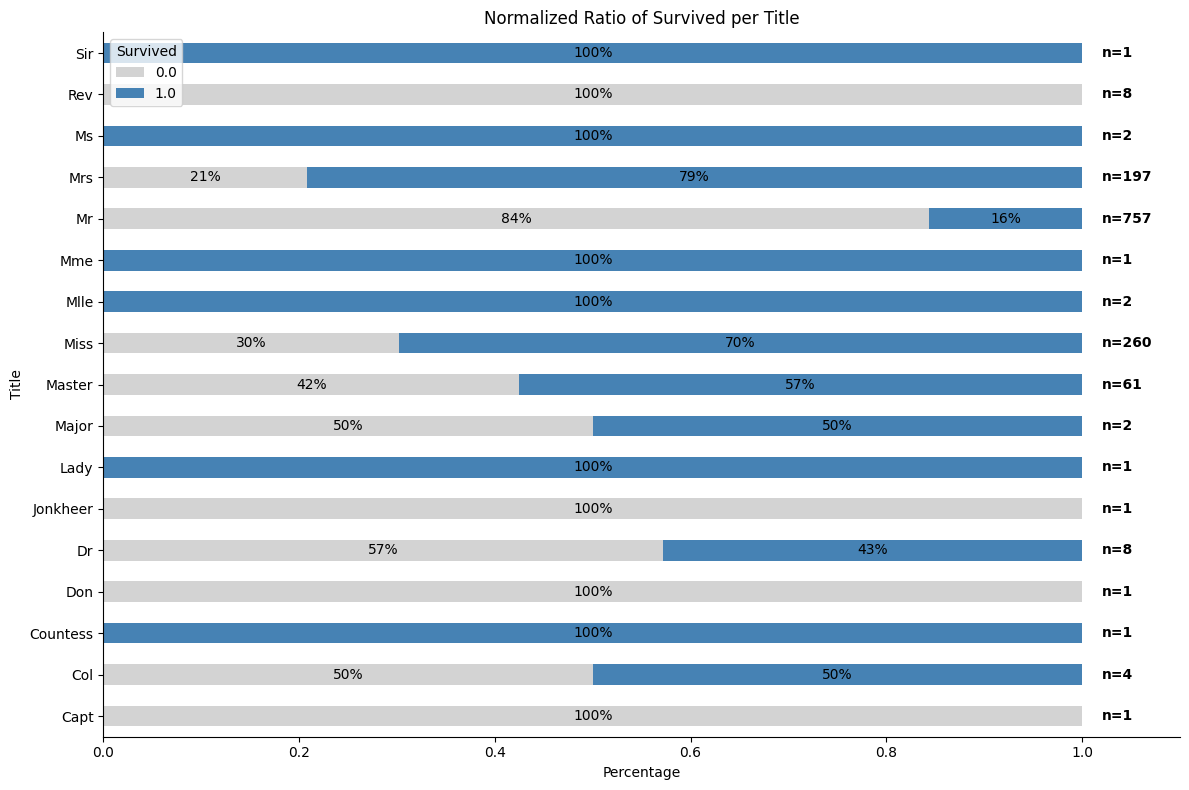

In [66]:
# Check the number of survivors by Title(get from name)
utils.plot_binary_ratio_by_category(datamart, 'Title', 'Survived')

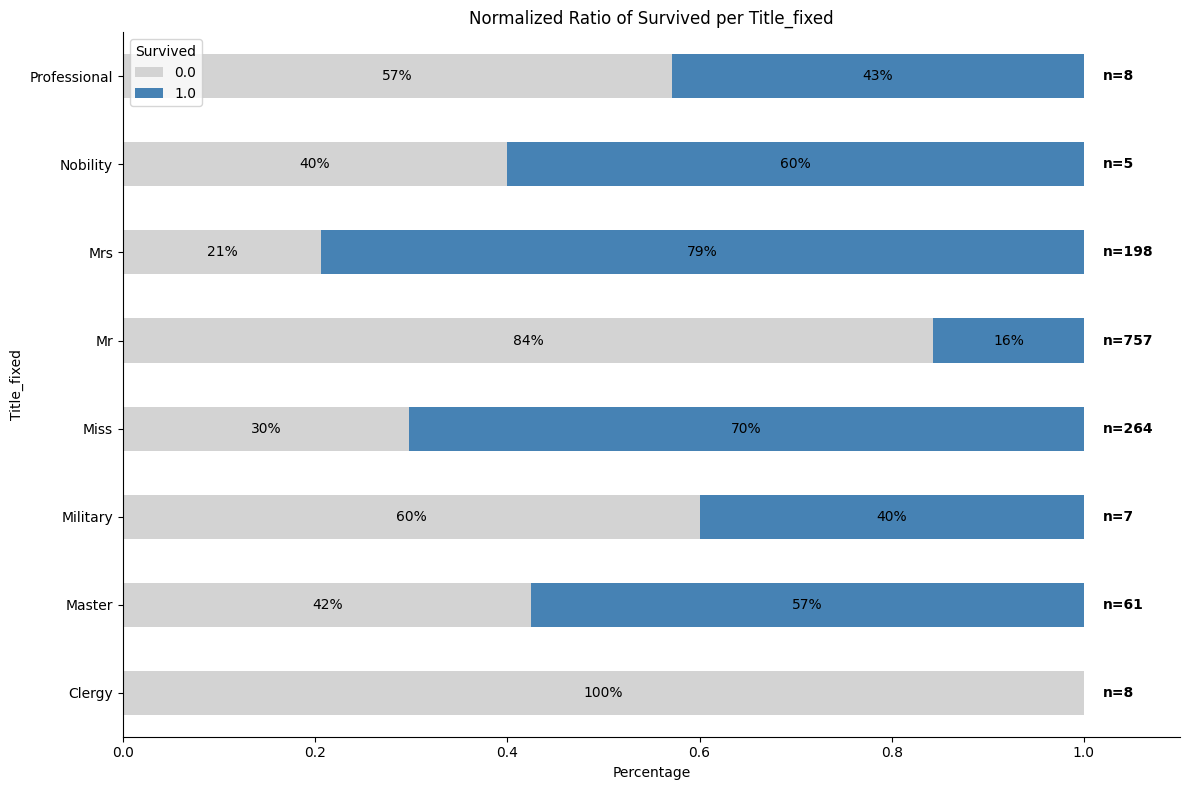

In [67]:
# Check the number of survivors by Title fixed
utils.plot_binary_ratio_by_category(datamart, 'Title_fixed', 'Survived')

In [68]:
datamart[datamart['Fare'] > 500]

# Same Ticket No, Maybe Same Cabin?

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data_type,CabinDeck,Title,Title_fixed
258,259,1.0,1,"Ward, Miss. Anna",female,35.0,0.0,0.0,PC 17755,512.3292,NaN,C,train,Unknown,Miss,Miss
679,680,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0.0,1.0,PC 17755,512.3292,B51 B53 B55,C,train,B,Mr,Mr
737,738,1.0,1,"Lesurer, Mr. Gustave J",male,35.0,0.0,0.0,PC 17755,512.3292,B101,C,train,B,Mr,Mr
1234,1235,NaN,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0.0,1.0,PC 17755,512.3292,B51 B53 B55,C,test,B,Mrs,Mrs


# 2. Feature engineering

In [69]:
# Missing values in the Embarked column are filled with the mode.
datamart['Embarked_filled'] = utils.fill_embarked_with_mode(datamart,'Embarked')

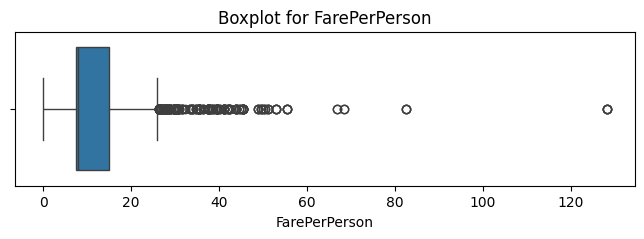

In [74]:
utils.plot_outliers(datamart,'FarePerPerson')

In [72]:
# Calculate SibSp + Parch + 1 (= Family Size) and TicketGroupSize.
datamart['FamilySize'] = datamart['SibSp'] + datamart['Parch'] + 1
datamart['TicketGroupSize'] = datamart.groupby('Ticket')['Ticket'].transform('count')
# Since each passenger's Fare represents the total amount paid by their TicketGroupSize rather than an individual payment, 
# we divide the Fare by the TicketGroupSize to convert it to the per-person fare.
datamart['FarePerPerson'] = datamart['Fare'] / datamart['TicketGroupSize']
datamart['FarePerPerson'] = datamart['FarePerPerson'].replace([np.inf, -np.inf], np.nan).fillna(0)
datamart = utils.standardize_column(datamart,'FarePerPerson')

In [75]:
utils.evaluate_null_int_columns_prediction_model(datamart, column='Age', features=['Pclass', 'SibSp', 'Parch', 'Fare','Title'])
utils.evaluate_null_int_columns_prediction_model(datamart, column='Age', features=['Pclass', 'SibSp', 'Parch', 'FarePerPerson','Title'])

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 RMSE: 9.68
 MAE : 7.50
 R²  : 0.44
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 RMSE: 9.90
 MAE : 7.79
 R²  : 0.41


In [94]:
utils.evaluate_null_int_columns_prediction_model(datamart, column='Age', features=['Pclass', 'SibSp', 'Parch', 'Fare','Title','Embarked_filled'])

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

 RMSE: 9.73
 MAE : 7.60
 R²  : 0.43


In [90]:
def get_ticket_groups_with_mixed_cabin(df):
    """
    같은 Ticket을 가진 사람들 중 Cabin 값이 null인 사람과 null이 아닌 사람이 모두 존재하는 그룹을 반환
    """
    # 그룹별로 cabin null 여부가 혼재한 그룹 찾기
    mixed_tickets = df.groupby("Ticket")["Cabin"].apply(lambda x: x.isnull().any() and x.notnull().any())

    # 혼재 그룹의 Ticket만 필터링
    valid_tickets = mixed_tickets[mixed_tickets].index

    # 해당 그룹 전체 추출
    return df[df["Ticket"].isin(valid_tickets)]
get_ticket_groups_with_mixed_cabin(datamart)[['PassengerId','Pclass','Name','Ticket','Cabin','Fare']].sort_values(by='Ticket').head()

,PassengerId,Pclass,Name,Ticket,Cabin,Fare
1197,1198,1,"Allison, Mr. Hudson Joshua Creighton",113781,C22 C26,151.55
708,709,1,"Cleaver, Miss. Alice",113781,NaN,151.55
297,298,1,"Allison, Miss. Helen Loraine",113781,C22 C26,151.55
305,306,1,"Allison, Master. Hudson Trevor",113781,C22 C26,151.55
1032,1033,1,"Daniels, Miss. Sarah",113781,NaN,151.55


In [ ]:
def fill_cabin_by_ticket(df):
    df = df.copy()

    # 그룹별 Cabin 값 중 첫 번째 non-null 값을 모든 사람에게 할당
    df["Cabin_filled"] = df.groupby("Ticket")["Cabin"].transform(lambda x: x.ffill().bfill())

    return df

df_filled = fill_cabin_by_ticket(datamart)

# 결과 확인
null_summary_datamart= pd.DataFrame({
    'null_count': datamart.isnull().sum(),
    'null_ratio': datamart.isnull().mean()
})
print(null_summary_datamart)

null_summary_df_filled= pd.DataFrame({
    'null_count': df_filled.isnull().sum(),
    'null_ratio': df_filled.isnull().mean()
})
print(null_summary_df_filled)

                 null_count  null_ratio
PassengerId               0    0.000000
Survived                418    0.319328
Pclass                    0    0.000000
Name                      0    0.000000
Sex                       0    0.000000
Age                     263    0.200917
SibSp                     0    0.000000
Parch                     0    0.000000
Ticket                    0    0.000000
Fare                      1    0.000764
Cabin                  1014    0.774637
Embarked                  2    0.001528
data_type                 0    0.000000
CabinDeck                 0    0.000000
Title                     0    0.000000
Title_fixed               0    0.000000
Embarked_filled           0    0.000000
FamilySize                0    0.000000
TicketGroupSize           0    0.000000
FarePerPerson             0    0.000000
FarePerPerson_z           0    0.000000
                 null_count  null_ratio
PassengerId               0    0.000000
Survived                418    0.319328


In [ ]:
# Since predicting age as an integer is difficult, I will convert it into categorical form and make predictions based on that.
conditions = [
    datamart["Age"] < 16,
    datamart["Age"] < 60
]
choices = [0, 1]

datamart["AgeGroup"] = np.select(conditions, choices, default=2)
datamart.loc[datamart["Age"].isnull(), "AgeGroup"] = np.nan

In [ ]:
# Ticket별 인원 수 계산
ticket_counts = datamart['Ticket'].value_counts()

# 각 행에 티켓 인원 수 할당
datamart['FarePerPerson'] = datamart.apply(lambda row: row['Fare'] / ticket_counts[row['Ticket']], axis=1)


In [ ]:
datamart.loc[~datamart["Age"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data_type,CabinDeck,Title,Title_fixed,FamilySize,TicketGroupSize,AgeGroup,FarePerPerson
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,train,Unknown,Mr,Mr,2.0,1,1.0,7.250000
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,train,C,Mrs,Mrs,2.0,2,1.0,35.641650
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,train,Unknown,Miss,Miss,1.0,1,1.0,7.925000
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,train,C,Mrs,Mrs,2.0,2,1.0,26.550000
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S,train,Unknown,Mr,Mr,1.0,1,1.0,8.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.0,1.0,1.0,SOTON/O.Q. 3101315,13.7750,NaN,S,test,Unknown,Miss,Miss,3.0,3,0.0,4.591667
1302,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1.0,0.0,19928,90.0000,C78,Q,test,C,Mrs,Mrs,2.0,3,1.0,30.000000
1303,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0.0,0.0,347086,7.7750,NaN,S,test,Unknown,Miss,Miss,1.0,1,1.0,7.775000
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0.0,0.0,PC 17758,108.9000,C105,C,test,C,Dona,Others,1.0,3,1.0,36.300000


In [ ]:
utils.evaluate_null_categorical_column_prediction_model(datamart, column='AgeGroup', features=['Pclass', 'FamilySize', 'FarePerPerson', 'Title_fixed', 'CabinDeck'])

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best hyperparameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75        35
         1.0       0.93      0.84      0.88       267
         2.0       0.08      0.25      0.12        12

    accuracy                           0.81       314
   macro avg       0.58      0.62      0.58       314
weighted avg       0.88      0.81      0.84       314



In [ ]:
null_summary_datamart = pd.DataFrame({
    'null_count': datamart.isnull().sum(),
    'null_ratio': datamart.isnull().mean()
})
print(null_summary_datamart)

                 null_count  null_ratio
PassengerId               0    0.000000
Survived                418    0.319328
Pclass                    0    0.000000
Name                      0    0.000000
Sex                       0    0.000000
Age                     263    0.200917
SibSp                     0    0.000000
Parch                     0    0.000000
Ticket                    0    0.000000
Fare                      1    0.000764
Cabin                  1014    0.774637
Embarked                  2    0.001528
data_type                 0    0.000000
CabinDeck                 0    0.000000
Title                     0    0.000000
Title_fixed               0    0.000000
FamilySize                0    0.000000
TicketGroupSize           0    0.000000
AgeGroup                263    0.200917
FarePerPerson             1    0.000764


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,data_type,CabinDeck,Title,Title_fixed,FamilySize,TicketGroupSize,AgeGroup,FarePerPerson
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0.0,0.0,3701,NaN,NaN,S,test,Unknown,Mr,Mr,1.0,1,2.0,NaN


In [ ]:
utils.evaluate_null_categorical_column_prediction_model_rf(datamart, category_col='AgeGroup', features=['Pclass', 'FamilySize', 'Title_fixed', 'CabinDeck'])

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.83      0.59        35
         1.0       0.88      0.30      0.45       267
         2.0       0.03      0.42      0.06        12

    accuracy                           0.37       314
   macro avg       0.46      0.52      0.37       314
weighted avg       0.80      0.37      0.45       314

